In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from models import cox_ph


import sys
sys.path.append("../")
from pathlib import Path
from Utils.Get_mvas import get_mvas_single_param, get_mvas_combined_params, get_events
from Utils.Combine_datasets import combine_mvas_adni, post_imputation_processing
from Utils.Data_imputation import impute_data, store_csv
from models import rubin_eval_cox, set_coef_test

# Importing datasets

In [2]:
#Load in the data
import yaml
path = '../Datasets/Imputed/ADNI3_BL/'
conf_path = Path(f"{path}setup.yaml")
dfs_train = []
dfs_test = []

if not conf_path.exists():
        print('Configuration file not found')
with open(conf_path) as f:
    config = yaml.safe_load(f)

columns_to_keep = ['AGE', 'PTEDUCAT', 'APOE4', 'CDRSB', 'ADAS11', 
                   'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'LDELTOTAL', 
                   'FAQ', 'MOCA', 'Event', 'PTGENDER_Male', 'M','ENTORHINAL_SUVR', 
                   'INFERIOR_TEMPORAL_SUVR', 'TAU_METAROI', ]
for i in range(config['num_datasets']):
    df_train = pd.read_csv(f"{path}/dataset_{i}/train.csv")[columns_to_keep]#.drop(columns, axis=1)
    dfs_train.append(df_train)
    df_test = pd.read_csv(f"{path}/dataset_{i}/test.csv").dropna()[columns_to_keep]#.drop(columns, axis=1)
    dfs_test.append(df_test)


print(dfs_train[0].shape,"\n", dfs_train[0]['Event'].value_counts())
print(dfs_test[0].shape,"\n", dfs_test[0]['Event'].value_counts())

(202, 18) 
 Event
False    167
True      35
Name: count, dtype: int64
(51, 18) 
 Event
False    42
True      9
Name: count, dtype: int64


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(dfs_train[0].columns.to_list())

['AGE',
 'PTEDUCAT',
 'APOE4',
 'CDRSB',
 'ADAS11',
 'ADAS13',
 'ADASQ4',
 'MMSE',
 'RAVLT_immediate',
 'LDELTOTAL',
 'FAQ',
 'MOCA',
 'Event',
 'PTGENDER_Male',
 'M',
 'ENTORHINAL_SUVR',
 'INFERIOR_TEMPORAL_SUVR',
 'TAU_METAROI']

# Cox vanilla model

In [4]:
cphs = []
variables = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=False, verbose=False)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables.append((c_index, penalizer))
    cphs.append(cph)
scores = [x[0] for x in variables]
print(f"Final score mean: {np.mean(scores)}\t std: {np.std(scores)}")
print(f"{np.mean(scores):.3f} $\pm$ {np.std(scores):.3f}")


Dataset 0
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8987341772151899, Penalizer: 0
Dataset 1
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.7468354430379747, Penalizer: 0
Dataset 2
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8945147679324894, Penalizer: 0
Dataset 3
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.890295358649789, Penalizer: 0
Dataset 4
Train shape: (202, 18), Test shape: (51, 18)


c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


Score: 0.8776371308016878, Penalizer: 0
Dataset 5
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8270042194092827, Penalizer: 0
Dataset 6
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8860759493670886, Penalizer: 0
Dataset 7
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.869198312236287, Penalizer: 0
Dataset 8
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8734177215189873, Penalizer: 0
Dataset 9
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8607594936708861, Penalizer: 0
Dataset 10
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8565400843881856, Penalizer: 0
Dataset 11
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8481012658227848, Penalizer: 0
Dataset 12
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.869198312236287, Penalizer: 0
Dataset 13
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.869198312236287, Penalizer: 0
Dataset 14
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8860759493670886, Penalizer: 0
Dataset 

In [5]:
results = rubin_eval_cox(cphs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.3}'.format
display(results)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
AGE,0.00614,1.01,0.0376,-0.0676,0.0799,0.935,1.08,0.163,0.87,0.2
PTEDUCAT,0.0807,1.08,0.0869,-0.0895,0.251,0.914,1.29,0.929,0.353,1.5
APOE4,0.0208,1.02,0.396,-0.755,0.797,0.47,2.22,0.0524,0.958,0.0616
CDRSB,0.0543,1.06,0.217,-0.37,0.479,0.69,1.61,0.251,0.802,0.318
ADAS11,-0.452,0.636,0.213,-0.869,-0.0342,0.419,0.966,-2.12,0.034,4.88
ADAS13,0.369,1.45,0.195,-0.0141,0.751,0.986,2.12,1.89,0.0591,4.08
ADASQ4,-0.123,0.884,0.215,-0.545,0.299,0.58,1.35,-0.571,0.568,0.817
MMSE,-0.095,0.909,0.147,-0.382,0.192,0.682,1.21,-0.648,0.517,0.952
RAVLT_immediate,-0.0359,0.965,0.03,-0.0948,0.0229,0.91,1.02,-1.2,0.231,2.11


In [6]:
coef = results['coef']
baseline_hazards = [indv_model.baseline_hazard_ for indv_model in cphs]

scores_c, scores_ipcw, scores_ibs = set_coef_test(coef, dfs_train, dfs_test, baseline_hazards)

print(f"Final C-index score mean: {np.mean(scores_c):.3f} $\pm$ {np.std(scores_c):.3f}")
print(f"Final IPCW score mean: {np.mean(scores_ipcw):.3f} $\pm$ {np.std(scores_ipcw):.3f}")
print(f"Final IBS score mean: {np.mean(scores_ibs):.3f} $\pm$ {np.std(scores_ibs):.3f}")

Final C-index score mean: 0.878 $\pm$ 0.013
Final IPCW score mean: 0.890 $\pm$ 0.015
Final IBS score mean: 0.163 $\pm$ 0.006


# Cox PH with penalty (Ridge)

In [7]:
cphs_ridge = []
variables_ridge = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, verbose=False, l1_ratio=0.0)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_ridge.append((c_index, penalizer))
    cphs_ridge.append(cph)

scores_ridge = [x[0] for x in variables_ridge]
print(f"Final score mean: {np.mean(scores_ridge)}\t std: {np.std(scores_ridge)}")
print(f"{np.mean(scores_ridge):.3f} $\pm$ {np.std(scores_ridge):.3f}")

Dataset 0
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9029535864978903, Penalizer: 0.1
Dataset 1
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.2
Dataset 2
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9156118143459916, Penalizer: 0.4
Dataset 3
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.05
Dataset 4
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.2
Dataset 5
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.4
Dataset 6
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.919831223628692, Penalizer: 0.2
Dataset 7
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.5
Dataset 8
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.2
Dataset 9
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.890295358649789, Penalizer: 0.2
Dataset 10
Train shape: (202, 1

In [8]:
results_ridge = rubin_eval_cox(cphs_ridge)
display(results_ridge.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MMSE,-0.053,0.949,0.062,-0.174,0.068,0.84,1.07,-0.855,0.392,1.35
LDELTOTAL,-0.018,0.982,0.027,-0.071,0.034,0.932,1.03,-0.68,0.497,1.01
RAVLT_immediate,-0.011,0.99,0.013,-0.035,0.014,0.965,1.01,-0.831,0.406,1.3
MOCA,-0.003,0.997,0.038,-0.077,0.072,0.925,1.07,-0.076,0.94,0.09
APOE4,-0.001,0.999,0.172,-0.338,0.336,0.713,1.4,-0.006,0.995,0.007
ADAS11,-0.001,0.999,0.033,-0.066,0.064,0.936,1.07,-0.027,0.979,0.031
AGE,0.001,1.0,0.016,-0.03,0.031,0.971,1.03,0.042,0.966,0.05
ADAS13,0.014,1.01,0.022,-0.029,0.056,0.972,1.06,0.637,0.524,0.933
PTGENDER_Male,0.015,1.01,0.229,-0.434,0.464,0.648,1.59,0.065,0.948,0.077


In [9]:
coef_ridge = results_ridge['coef']
baseline_hazards = [indv_model.baseline_hazard_ for indv_model in cphs_ridge]

scores_c_ridge, scores_ipcw_ridge, scores_ibs_ridge = set_coef_test(coef_ridge, dfs_train, dfs_test, baseline_hazards)

print(f"Final C-index score mean: {np.mean(scores_c_ridge):.3f} $\pm$ {np.std(scores_c_ridge):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_ridge):.3f} $\pm$ {np.std(scores_ipcw_ridge):.3f}")
print(f"Final IBS score mean: {np.mean(scores_ibs_ridge):.3f} $\pm$ {np.std(scores_ibs_ridge):.3f}")

Final C-index score mean: 0.909 $\pm$ 0.009
Final IPCW C-index score mean: 0.904 $\pm$ 0.031
Final IBS score mean: 0.236 $\pm$ 0.001


# Cox PH with penalty (Lasso)

In [10]:
cphs_lasso = []
variables_lasso = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, verbose=False, l1_ratio=1.0)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_lasso.append((c_index, penalizer))
    cphs_lasso.append(cph)
scores_lasso = [x[0] for x in variables_lasso]
print(f"Final score mean: {np.mean(scores_lasso)}\t std: {np.std(scores_lasso)}")
print(f"{np.mean(scores_lasso):.3f} $\pm$ {np.std(scores_lasso):.3f}")


Dataset 0
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8607594936708861, Penalizer: 0.1
Dataset 1
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9367088607594937, Penalizer: 0.01
Dataset 2
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8945147679324894, Penalizer: 0.05
Dataset 3
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9029535864978903, Penalizer: 0.4
Dataset 4
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8860759493670886, Penalizer: 0.1
Dataset 5
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.05
Dataset 6
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8776371308016878, Penalizer: 0.1
Dataset 7
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8987341772151899, Penalizer: 0.1
Dataset 8
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8734177215189873, Penalizer: 0.1
Dataset 9
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8227848101265823, Penalizer: 0.1
Dataset 10
Train shape: (20

c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=1.08442e-16): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=8.27107e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=6.50262e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=5.07653e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
c:\Users\dbior\miniforge3\Lib\site-packa

Score: 0.8945147679324894, Penalizer: 0.3
Dataset 19
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8945147679324894, Penalizer: 0.01
Dataset 20
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.5
Dataset 21
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.919831223628692, Penalizer: 0.5
Dataset 22
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.05
Dataset 23
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8945147679324894, Penalizer: 0.05
Dataset 24
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.4
Final score mean: 0.8901265822784811	 std: 0.026751986566851727
0.890 $\pm$ 0.027


In [11]:
results_lasso = rubin_eval_cox(cphs_lasso)
display(results_lasso.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
RAVLT_immediate,-0.003,0.997,0.013,-0.027,0.022,0.973,1.02,-0.215,0.829,0.27
MMSE,-0.002,0.998,0.042,-0.084,0.08,0.919,1.08,-0.056,0.955,0.066
ADAS11,-0.001,0.999,0.019,-0.039,0.036,0.962,1.04,-0.064,0.949,0.076
LDELTOTAL,-0.0,1.0,0.012,-0.023,0.023,0.977,1.02,-0.003,0.998,0.004
APOE4,-0.0,1.0,0.0,-0.001,0.001,0.999,1.0,-0.0,1.0,0.0
AGE,0.0,1.0,0.0,-0.0,0.0,1.0,1.0,0.0,1.0,0.0
ADAS13,0.0,1.0,0.0,-0.0,0.0,1.0,1.0,0.001,1.0,0.001
MOCA,0.001,1.0,0.016,-0.03,0.032,0.971,1.03,0.07,0.944,0.083
PTEDUCAT,0.003,1.0,0.023,-0.042,0.048,0.959,1.05,0.134,0.893,0.163


In [12]:
coef_lasso = results_lasso['coef']
baseline_hazards_lasso = [indv_model.baseline_hazard_ for indv_model in cphs_lasso]
scores_c_lasso, scores_ipcw_lasso, scores_ibs_lasso = set_coef_test(coef_lasso, dfs_train, dfs_test, baseline_hazards_lasso)

print(f"Final C-index score mean: {np.mean(scores_c_lasso):.3f} $\pm$ {np.std(scores_c_lasso):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_lasso):.3f} $\pm$ {np.std(scores_ipcw_lasso):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ibs_lasso):.3f} $\pm$ {np.std(scores_ibs_lasso):.3f}")

Final C-index score mean: 0.893 $\pm$ 0.019
Final IPCW C-index score mean: 0.875 $\pm$ 0.054
Final IPCW C-index score mean: 0.238 $\pm$ 0.000


# Cox PH with penalty (Elastic net)

In [13]:
cphs_elastic = []
variables_elastic = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):
    #Final cleanup post imputation
    print(f"Dataset {i}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    cph, c_index, penalizer = cox_ph(df_train, df_test, cross_validate=True, verbose=False, l1_ratio=0.5)
    print(f"Score: {c_index}, Penalizer: {penalizer}")
    
    variables_elastic.append((c_index, penalizer))
    cphs_elastic.append(cph)
scores_elastic = [x[0] for x in variables_elastic]
print(f"Final score mean: {np.mean(scores_elastic)}\t std: {np.std(scores_elastic)}")
print(f"{np.mean(scores_elastic):.3f} $\pm$ {np.std(scores_elastic):.3f}")


Dataset 0
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8945147679324894, Penalizer: 0.05
Dataset 1
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.1
Dataset 2
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.890295358649789, Penalizer: 0.2
Dataset 3
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8987341772151899, Penalizer: 0.1
Dataset 4
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.05
Dataset 5
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9071729957805907, Penalizer: 0.1
Dataset 6
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.5
Dataset 7
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.9113924050632911, Penalizer: 0.05
Dataset 8
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8227848101265823, Penalizer: 0.4
Dataset 9
Train shape: (202, 18), Test shape: (51, 18)
Score: 0.8860759493670886, Penalizer: 0.05
Dataset 10
Train shape: (20

In [14]:
results_elastic = rubin_eval_cox(cphs_elastic)
display(results_elastic.sort_values(by='coef').round(3))

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MMSE,-0.009,0.991,0.068,-0.142,0.124,0.868,1.13,-0.136,0.892,0.165
RAVLT_immediate,-0.005,0.995,0.016,-0.036,0.026,0.965,1.03,-0.318,0.751,0.414
LDELTOTAL,-0.002,0.998,0.029,-0.059,0.055,0.942,1.06,-0.079,0.937,0.094
MOCA,-0.0,1.0,0.0,-0.0,0.0,1.0,1.0,-0.0,1.0,0.0
APOE4,0.0,1.0,0.0,-0.001,0.001,0.999,1.0,0.0,1.0,0.0
AGE,0.0,1.0,0.0,-0.0,0.0,1.0,1.0,0.0,1.0,0.0
ADAS11,0.0,1.0,0.0,-0.0,0.0,1.0,1.0,0.0,1.0,0.001
PTGENDER_Male,0.0,1.0,0.001,-0.001,0.001,0.999,1.0,0.001,1.0,0.001
ADAS13,0.0,1.0,0.014,-0.028,0.029,0.973,1.03,0.028,0.978,0.033


In [15]:
coef_elastic = results_elastic['coef']
baseline_hazards_elastic = [indv_model.baseline_hazard_ for indv_model in cphs_elastic]
scores_c_elastic, scores_ipcw_elastic, scores_ibs_elastic = set_coef_test(coef_elastic, dfs_train, dfs_test, baseline_hazards_elastic)

print(f"Final C-index score mean: {np.mean(scores_c_elastic):.3f} $\pm$ {np.std(scores_c_elastic):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ipcw_elastic):.3f} $\pm$ {np.std(scores_ipcw_elastic):.3f}")
print(f"Final IPCW C-index score mean: {np.mean(scores_ibs_elastic):.3f} $\pm$ {np.std(scores_ibs_elastic):.3f}")

Final C-index score mean: 0.897 $\pm$ 0.015
Final IPCW C-index score mean: 0.880 $\pm$ 0.045
Final IPCW C-index score mean: 0.235 $\pm$ 0.001


# RSF

In [16]:
from models import survival_forest

rsfs = []
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test)):

    rsf, score, score_ipcw, score_bri = survival_forest(df_train, df_test, cross_validate=True, verbose=False)
    print(score)

    print(score, score_ipcw[0], score_bri)
    
    rsfs.append((rsf, score, score_ipcw[0], score_bri))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 300}
0.8987341772151899
0.8987341772151899 0.8005606413463237 0.10606333092233161
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 100}
0.9113924050632911
0.9113924050632911 0.9451578097535178 0.10231772453985134
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 200}
0.890295358649789
0.890295358649789 0.8603414804411923 0.11802192300658405
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 300}
0.9156118143459916
0.9156118143459916 0.8451871747368026 0.09648202242406485
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_f

In [17]:
scores_c_rsf = [x[1] for x in rsfs]
scores_ipcw_rsf = [x[2] for x in rsfs]
scores_ibs = [x[3] for x in rsfs]
print(f"C-index mean: {np.mean(scores_c_rsf):.3f} $\pm$ {np.std(scores_c_rsf):.3f}")
print(f"IPCW-C mean: {np.mean(scores_ipcw_rsf):.3f} $\pm$ {np.std(scores_ipcw_rsf):.3f}")
print(f"IBS mean: {np.mean(scores_ibs):.3f} $\pm$ {np.std(scores_ibs):.3f}")

C-index mean: 0.904 $\pm$ 0.014
IPCW-C mean: 0.892 $\pm$ 0.046
IBS mean: 0.108 $\pm$ 0.011


In [18]:
print("C-index:")
print(f"CPH: \t{np.mean(scores_c):.3f} $\pm$ {np.std(scores_c):.3f}")
print(f"Ridge: \t{np.mean(scores_c_ridge):.3f} $\pm$ {np.std(scores_c_ridge):.3f}")
print(f"Lasso: \t{np.mean(scores_c_lasso):.3f} $\pm$ {np.std(scores_c_lasso):.3f}")
print(f"Elast: \t{np.mean(scores_c_elastic):.3f} $\pm$ {np.std(scores_c_elastic):.3f}")
print(f"RSF: \t{np.mean(scores_c_rsf):.3f} $\pm$ {np.std(scores_c_rsf):.3f}")

print()
print("IPCW C:")
print(f"CPH: \t{np.mean(scores_ipcw):.3f} $\pm$ {np.std(scores_ipcw):.3f}")
print(f"Ridge: \t{np.mean(scores_ipcw_ridge):.3f} $\pm$ {np.std(scores_ipcw_ridge):.3f}")
print(f"Lasso: \t{np.mean(scores_ipcw_lasso):.3f} $\pm$ {np.std(scores_ipcw_lasso):.3f}")
print(f"Elast: \t{np.mean(scores_ipcw_elastic):.3f} $\pm$ {np.std(scores_ipcw_elastic):.3f}")
print(f"RSF: \t{np.mean(scores_ipcw_rsf):.3f} $\pm$ {np.std(scores_ipcw_rsf):.3f}")

print()
print("IBS:")
print(f"CPH: \t{np.mean(scores_ibs):.3f} $\pm$ {np.std(scores_ibs):.3f}")
print(f"Ridge: \t{np.mean(scores_ibs_ridge):.3f} $\pm$ {np.std(scores_ibs_ridge):.3f}")
print(f"Lasso: \t{np.mean(scores_ibs_lasso):.3f} $\pm$ {np.std(scores_ibs_lasso):.3f}")
print(f"Elast:\t{np.mean(scores_ibs_elastic):.3f} $\pm$ {np.std(scores_ibs_elastic):.3f}")
print(f"RSF: \t{np.mean(scores_ibs):.3f} $\pm$ {np.std(scores_ibs):.3f}")


C-index:
CPH: 	0.878 $\pm$ 0.013
Ridge: 	0.909 $\pm$ 0.009
Lasso: 	0.893 $\pm$ 0.019
Elast: 	0.897 $\pm$ 0.015
RSF: 	0.904 $\pm$ 0.014

IPCW C:
CPH: 	0.890 $\pm$ 0.015
Ridge: 	0.904 $\pm$ 0.031
Lasso: 	0.875 $\pm$ 0.054
Elast: 	0.880 $\pm$ 0.045
RSF: 	0.892 $\pm$ 0.046

IBS:
CPH: 	0.108 $\pm$ 0.011
Ridge: 	0.236 $\pm$ 0.001
Lasso: 	0.238 $\pm$ 0.000
Elast:	0.235 $\pm$ 0.001
RSF: 	0.108 $\pm$ 0.011


In [19]:
from sklearn.inspection import permutation_importance
from sksurv.datasets import get_x_y
random_state = 42
pd.options.display.float_format = '{:.5f}'.format


importance = []
for rsf, (df_train, df_test) in zip(rsfs, zip(dfs_train, dfs_test)):
    x_test, y_test = get_x_y(df_test, attr_labels=["Event", "M"], pos_label=1)
    result = permutation_importance(rsf[0], x_test, y_test, n_repeats=15, n_jobs=-1, random_state=random_state)
    importance.append(result)
    df_res = pd.DataFrame(
        {
            k: result[k]
            for k in (
                "importances_mean",
                "importances_std",
            )
        },
        index=x_test.columns,
    ).sort_values(by="importances_mean", ascending=False)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    # display(df_res.head(15))

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_colwidth')

In [20]:
all_importances = np.array([var['importances_mean'] for var in importance])
all_variances = np.array([var['importances_std'] for var in importance])

In [21]:
Q_bar = np.mean(all_importances, axis=0)  # Pooled importance means
U_bar = np.mean(all_variances, axis=0)    # Within-imputation variances
B = np.var(all_importances, axis=0, ddof=1)  # Between-imputation variances
from scipy.stats import norm


# Total variance
T = U_bar + (1 + 1/len(rsfs)) * B

# Standard errors
se = np.sqrt(T)

# Confidence intervals
alpha = 0.05
z_value = norm.ppf(1 - alpha / 2)
ci_lower = Q_bar - z_value * se
ci_upper = Q_bar + z_value * se

# Combine results into a DataFrame for easy viewing
feature_names = x_test.columns
results_rsf = pd.DataFrame({
    'importance_mean': Q_bar,
    'importance_se': se,
    'importance_ci_lower': ci_lower,
    'importance_ci_upper': ci_upper
}, index=feature_names)

# Sort by mean importance
results_rsf = results_rsf.sort_values(by='importance_mean', ascending=False)

display(results_rsf)

,importance_mean,importance_se,importance_ci_lower,importance_ci_upper
FAQ,0.02294,0.11364,-0.19978,0.24566
TAU_METAROI,0.02049,0.14246,-0.25872,0.29970
ADAS13,0.01285,0.10451,-0.19199,0.21769
CDRSB,0.01185,0.08408,-0.15294,0.17664
INFERIOR_TEMPORAL_SUVR,0.01051,0.13511,-0.25431,0.27533
ENTORHINAL_SUVR,0.00961,0.11076,-0.20748,0.22670
RAVLT_immediate,0.00639,0.07533,-0.14126,0.15404
PTEDUCAT,0.00246,0.04885,-0.09329,0.09822
ADAS11,0.00231,0.05691,-0.10923,0.11385
ADASQ4,0.00163,0.08408,-0.16316,0.16642


# Plots

In [22]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


font_path = '../Old_Standard_TT'
font_path_regular = f'{font_path}/OldStandardTT-Regular.ttf'
font_path_bold = f'{font_path}/OldStandardTT-Bold.ttf'
font_path_italic = f'{font_path}/OldStandardTT-Italic.ttf'

# Specify the direct path to your font file
# font_path_regular = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Regular.ttf'
# font_path_bold = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Bold.ttf'
# font_path_italic = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Italic.ttf'
# Create a FontProperties object with the full path to the font file
prop_regular = FontProperties(fname=font_path_regular)
prop_bold = FontProperties(fname=font_path_bold)
prop_italic = FontProperties(fname=font_path_italic)
my_colors = ['#B0DAFF', '#FFB085']

In [23]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


font_path = '../Old_Standard_TT'
font_path_regular = f'{font_path}/OldStandardTT-Regular.ttf'
font_path_bold = f'{font_path}/OldStandardTT-Bold.ttf'
font_path_italic = f'{font_path}/OldStandardTT-Italic.ttf'

# Specify the direct path to your font file
# font_path_regular = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Regular.ttf'
# font_path_bold = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Bold.ttf'
# font_path_italic = '/home/diego/.conda/envs/diego/fonts/OldStandardTT-Italic.ttf'
# Create a FontProperties object with the full path to the font file
prop_regular = FontProperties(fname=font_path_regular)
prop_bold = FontProperties(fname=font_path_bold)
prop_italic = FontProperties(fname=font_path_italic)
my_colors = ['#B0DAFF', '#FFB085']

def plot_errorbars(coef, ci_lower, ci_upper, path, title, yticks, figsize=(12, 10)):
    # Create an array for the positions on the y-axis
    y_pos = np.arange(len(coef))

    fig, ax = plt.subplots(figsize=figsize)

    # Plot the points with error bars
    ax.errorbar(coef, y_pos, xerr=[coef - ci_lower, ci_upper - coef], fmt='o', color='#91C6FF', ecolor='#FF8F61', capsize=6, zorder=3, markersize=12, linewidth=2.5, capthick=2.5 )

    # Add y-ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(yticks.index, fontsize=24, fontproperties=prop_regular)

    # Labels and title
    ax.set_xlabel('Coefficient', fontsize=28, fontproperties=prop_bold)
    ax.set_title(f'Coefficients and 95% Confidence Intervals of {title} Model', fontproperties=prop_bold, fontsize=32)

    # Set custom ticks for x-axis (optional, adjust as needed)
    # ax.set_xticks(np.arange(-3, 4, 1))
    ax.tick_params(axis='x', labelsize=2)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(12)
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(15)


    # Grid for better readability
    ax.grid(axis='y', zorder=0)

    # Add the grid lines for the y-axis
    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(f"./results/{path}.pdf")


In [24]:
baseline_hazards = []
models_list = [cphs, cphs_ridge, cphs_lasso, cphs_elastic]

for models in models_list:
    baseline_hazards_temp = [indv_model.baseline_hazard_ for indv_model in models]
    concatenated_baseline_hazards = pd.concat(baseline_hazards_temp, axis=1)
    pooled_baseline_hazard = concatenated_baseline_hazards.mean(axis=1)
    # print(pooled_baseline_hazard)
    baseline_hazards.append(pooled_baseline_hazard)
print(baseline_hazards)

[12.00000   0.01456
18.00000   0.00259
24.00000   0.02653
30.00000   0.00777
36.00000   0.01861
42.00000   0.00000
48.00000   0.10022
54.00000   0.00000
60.00000   0.15754
66.00000   0.00000
dtype: float64, 12.00000   0.03461
18.00000   0.00484
24.00000   0.04894
30.00000   0.01055
36.00000   0.02474
42.00000   0.00000
48.00000   0.10928
54.00000   0.00000
60.00000   0.14117
66.00000   0.00000
dtype: float64, 12.00000   0.04706
18.00000   0.00581
24.00000   0.05762
30.00000   0.01121
36.00000   0.02551
42.00000   0.00000
48.00000   0.11282
54.00000   0.00000
60.00000   0.14452
66.00000   0.00000
dtype: float64, 12.00000   0.04227
18.00000   0.00540
24.00000   0.05412
30.00000   0.01088
36.00000   0.02519
42.00000   0.00000
48.00000   0.11229
54.00000   0.00000
60.00000   0.14436
66.00000   0.00000
dtype: float64]


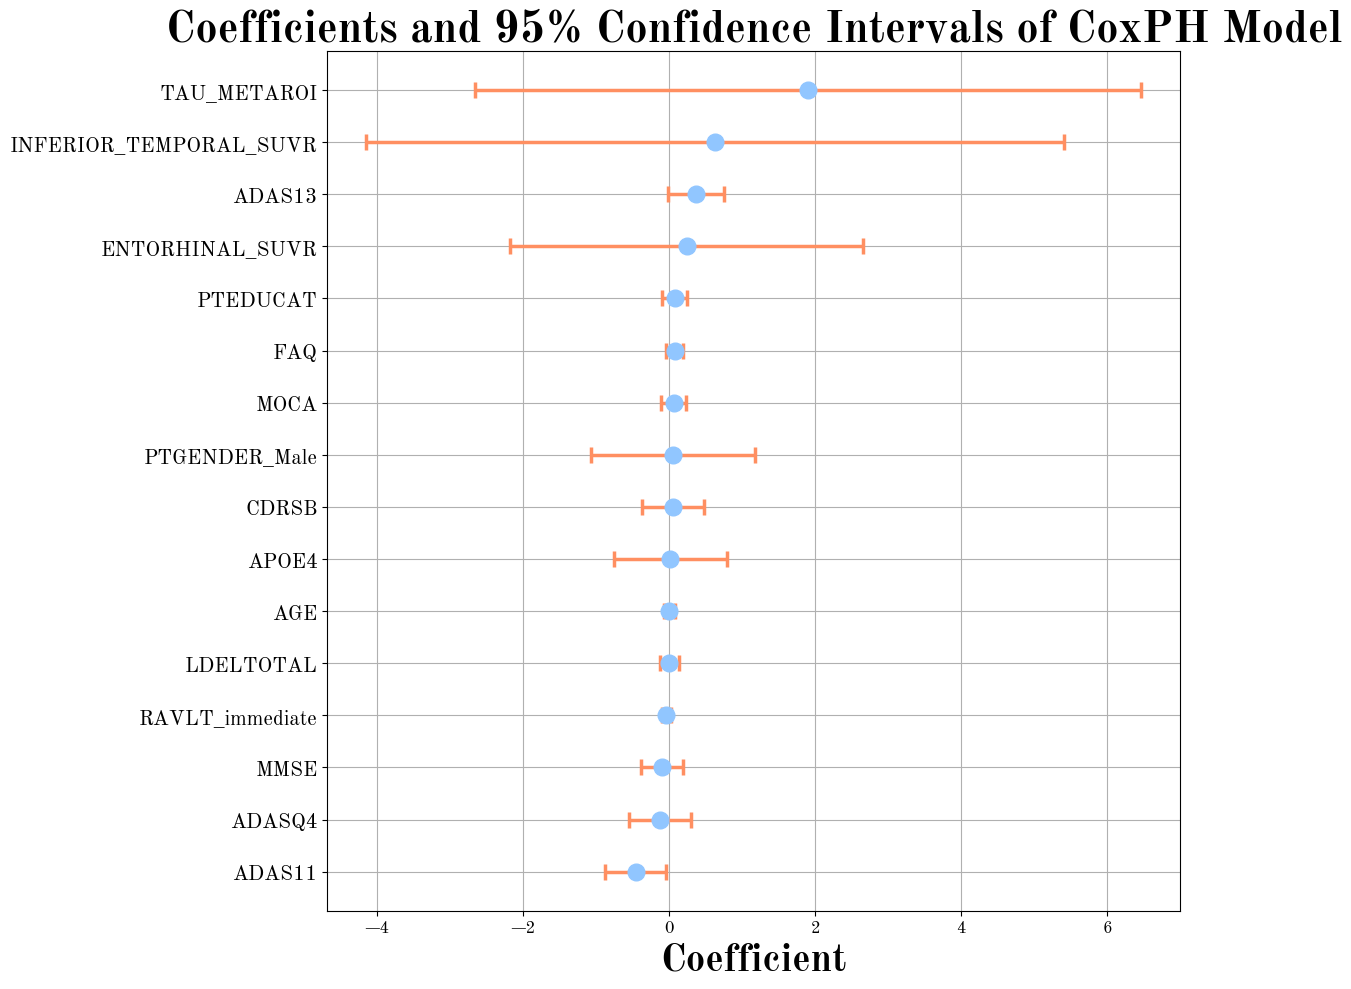

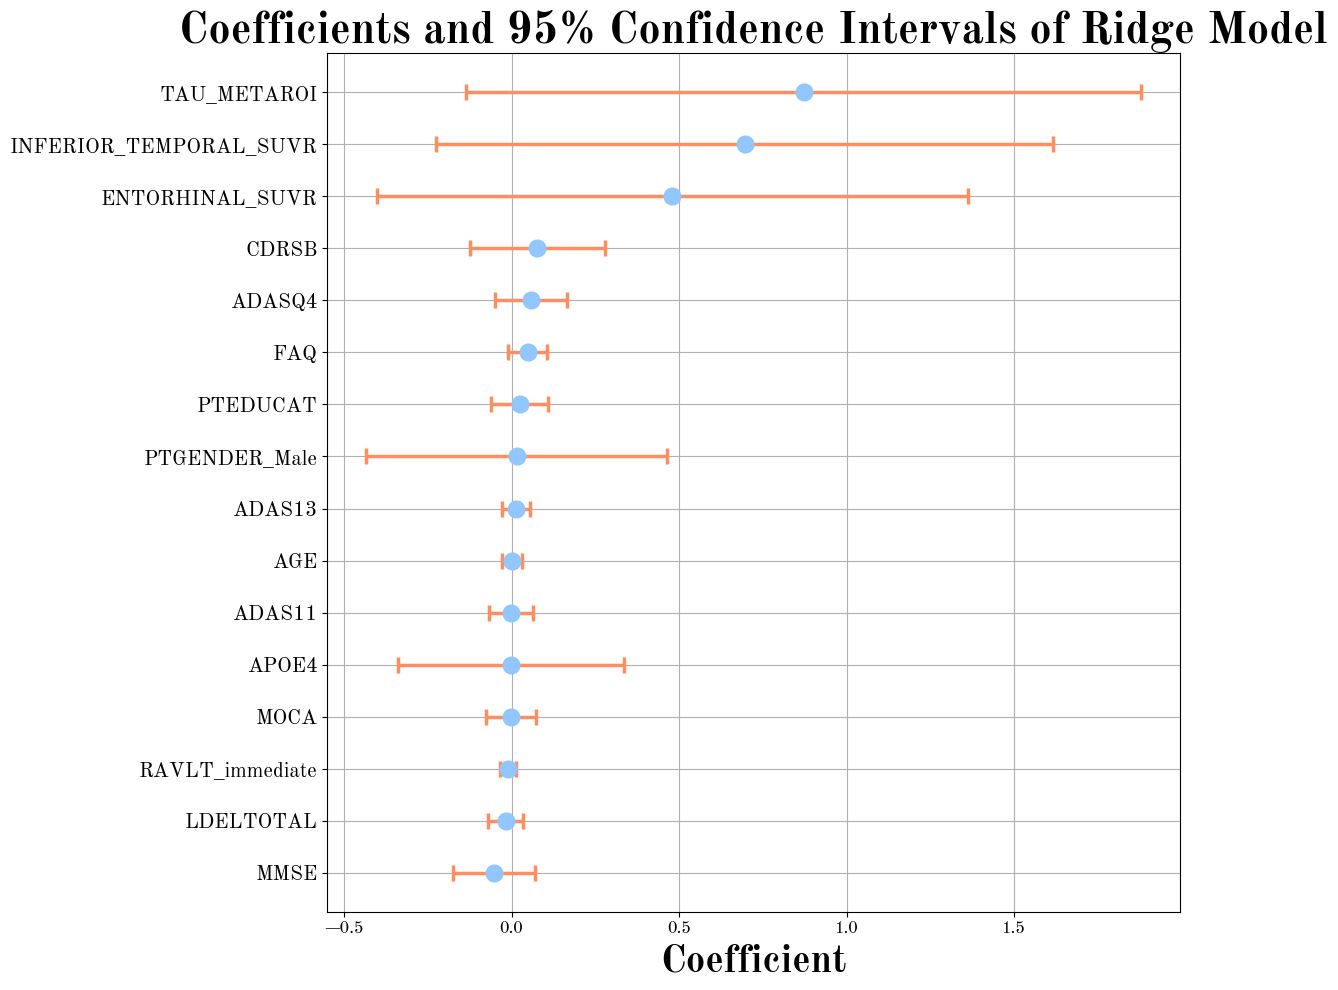

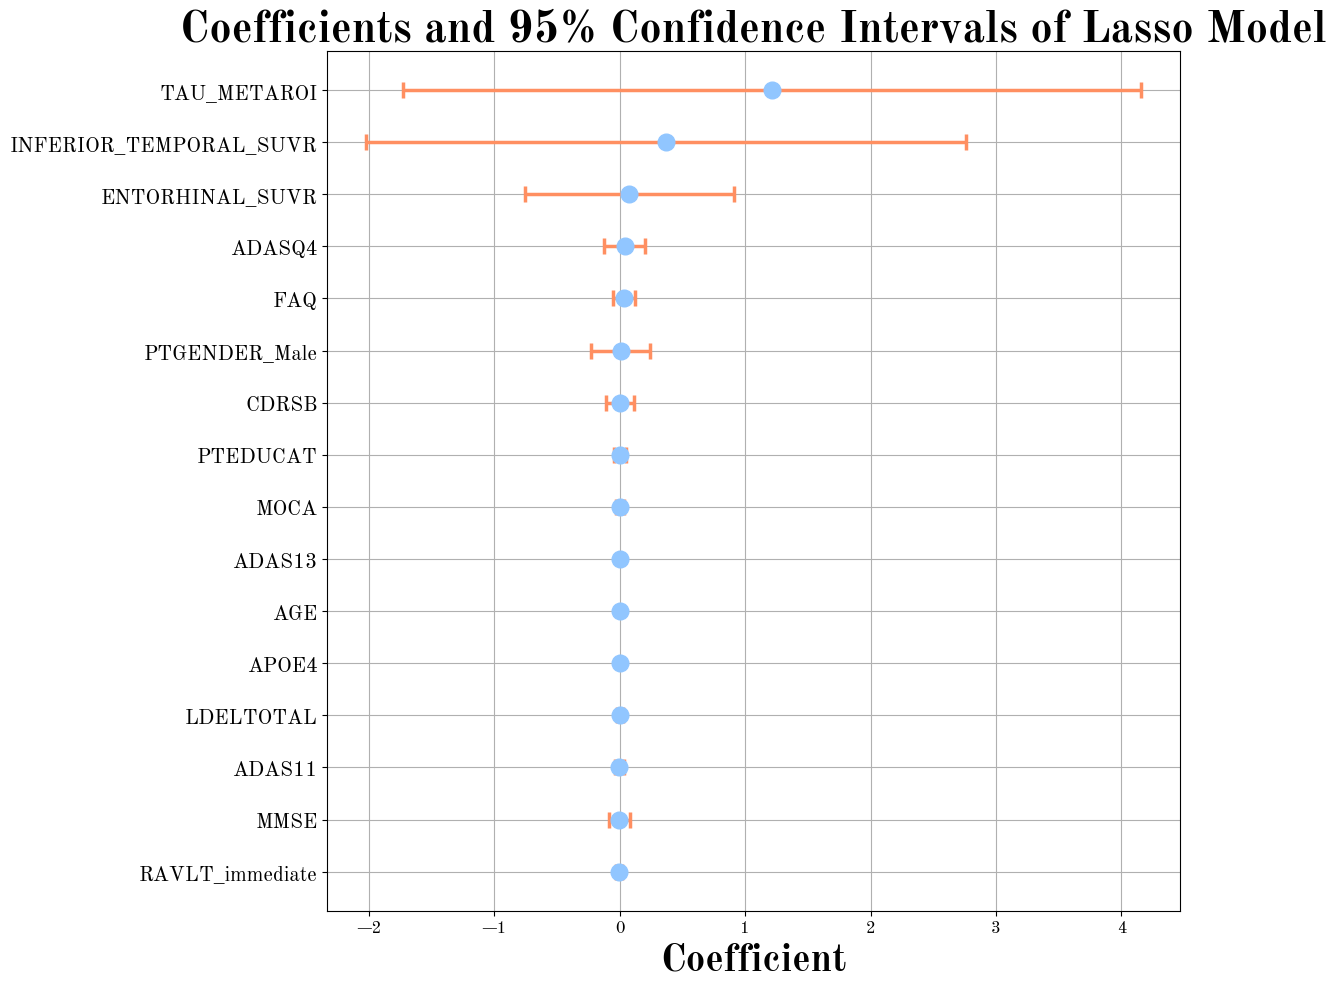

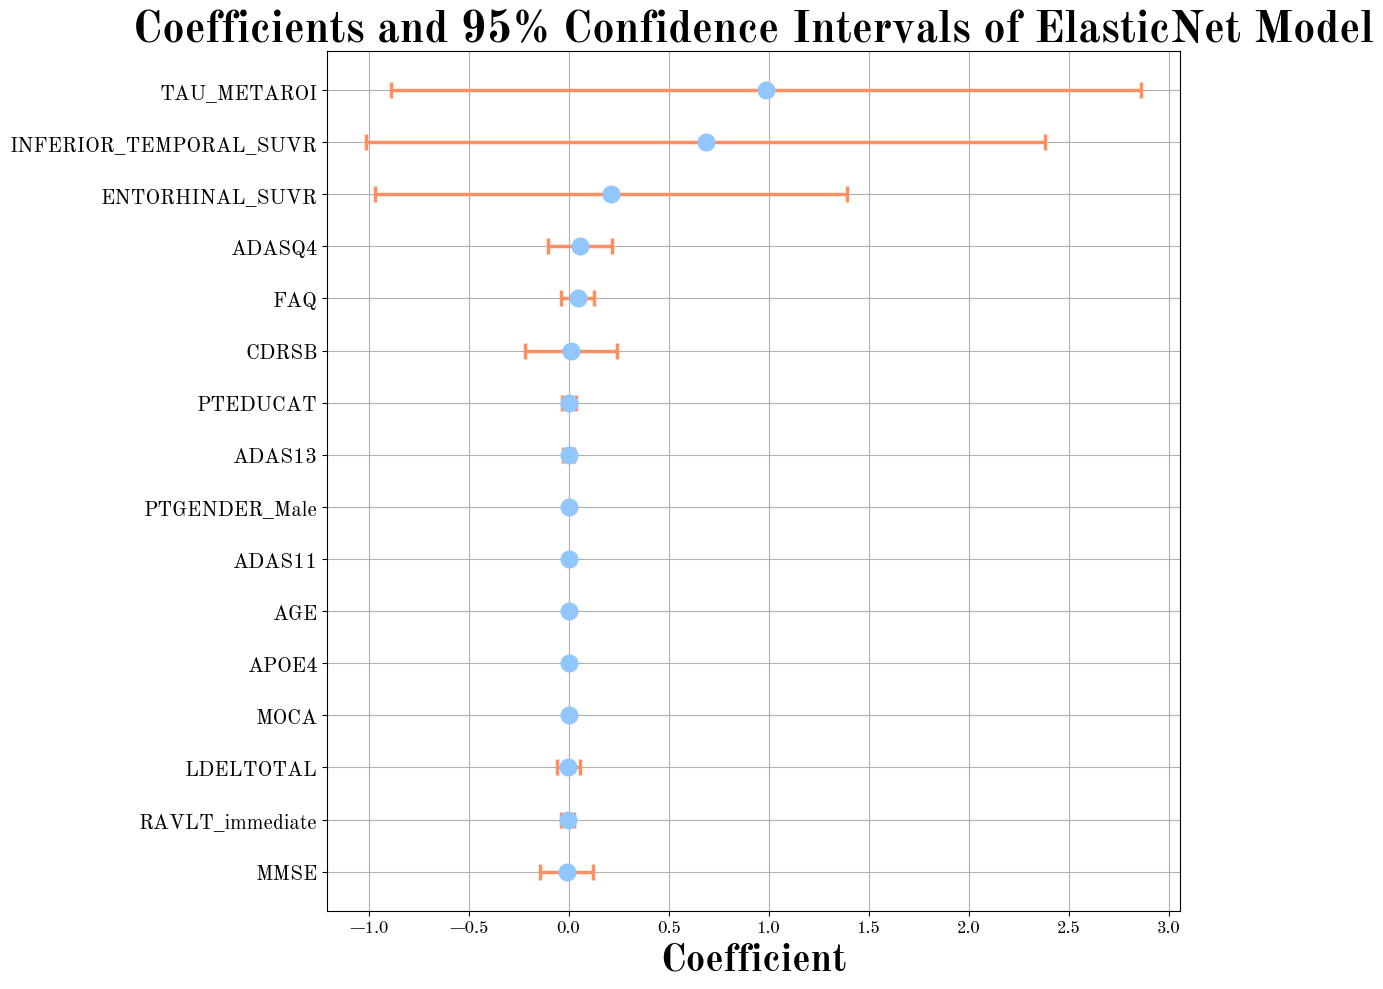

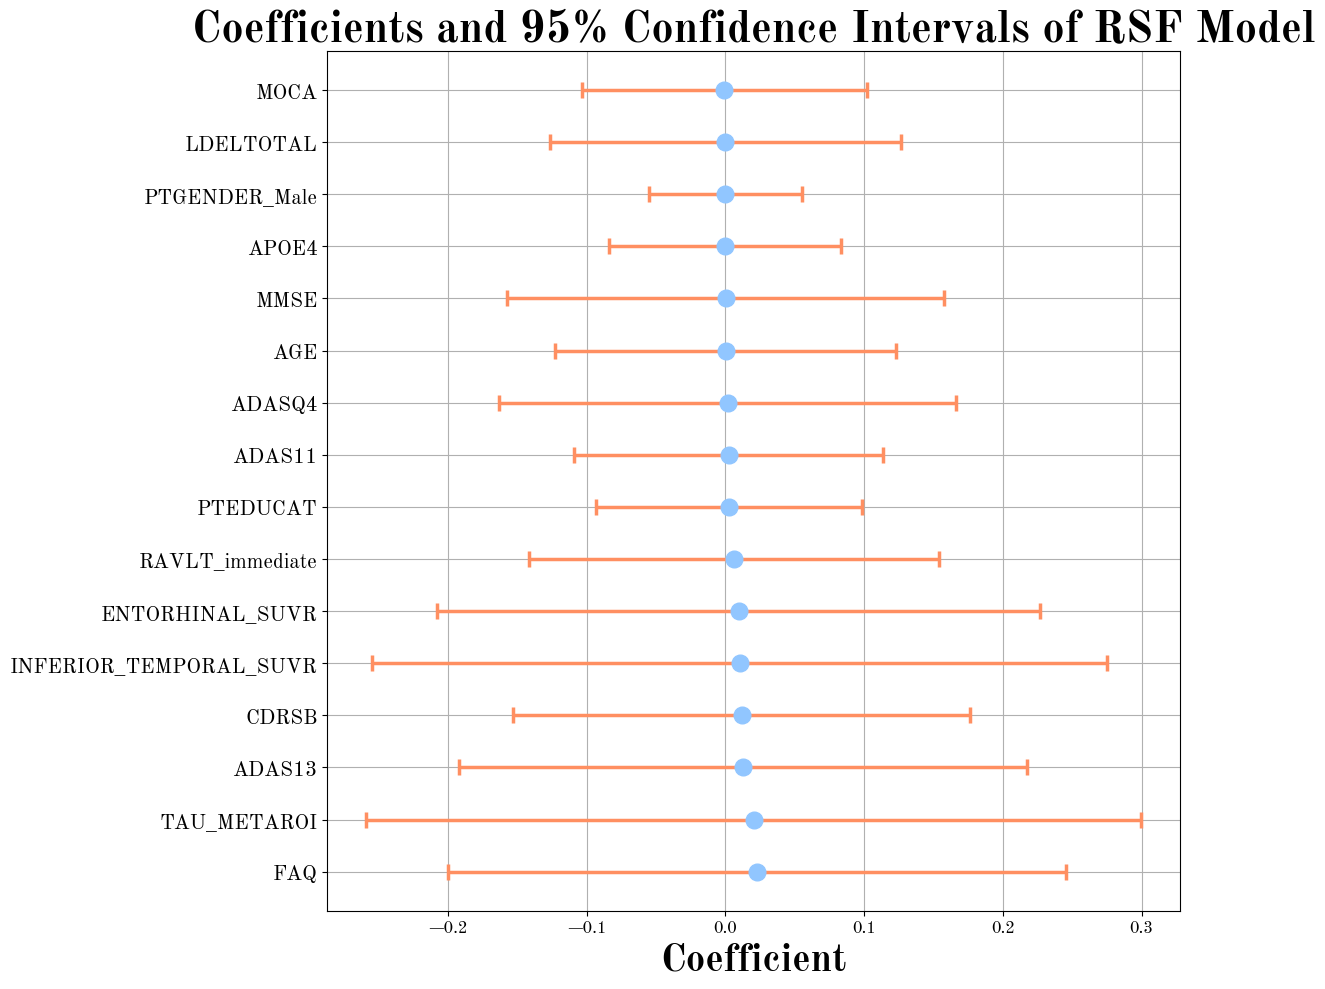

In [25]:
from Utils.plot_functions import plot_bar_difference
from sksurv.linear_model import CoxPHSurvivalAnalysis


cph_models_coef = [results, results_ridge, results_lasso, results_elastic]
labels = ['CoxPH', 'Ridge', 'Lasso', 'ElasticNet']
path = ['coxph','ridge', 'lasso', 'elastic']

model = CoxPHSurvivalAnalysis(alpha=0.1)
x_train, y_train = get_x_y(dfs_train[0], attr_labels=["Event", "M"], pos_label=1)
model.fit(x_train, y_train)


for i, params in enumerate(cph_models_coef):
    model.coef_ = params['coef']   
    params_ordered = params.sort_values(by='coef') 
    plot_errorbars(params_ordered['coef'], params_ordered['coef lower 95%'], params_ordered['coef upper 95%'], 'adni3/' + path[i], labels[i], params_ordered)

coef = results_rsf['importance_mean']
ci_lower = results_rsf['importance_ci_lower']
ci_upper = results_rsf['importance_ci_upper']
plot_errorbars(coef, ci_lower, ci_upper, 'adni3/rsf', 'RSF', results_rsf)

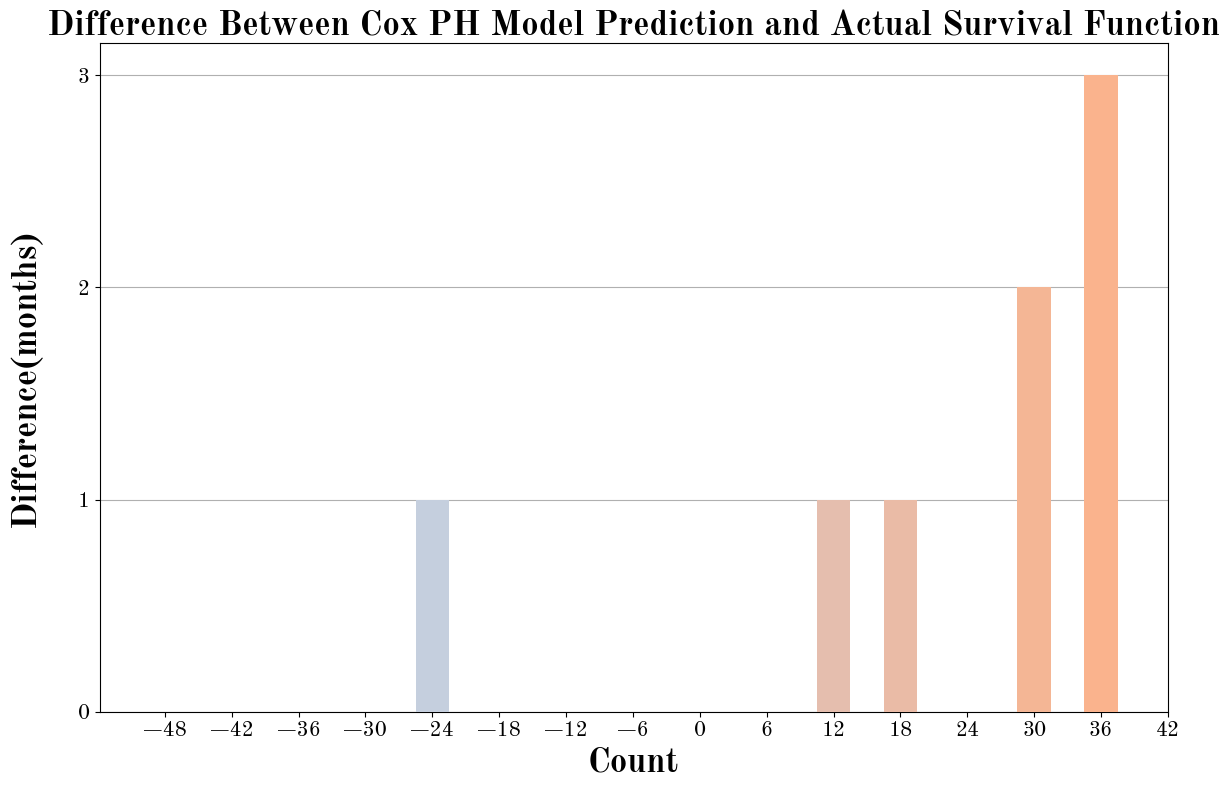

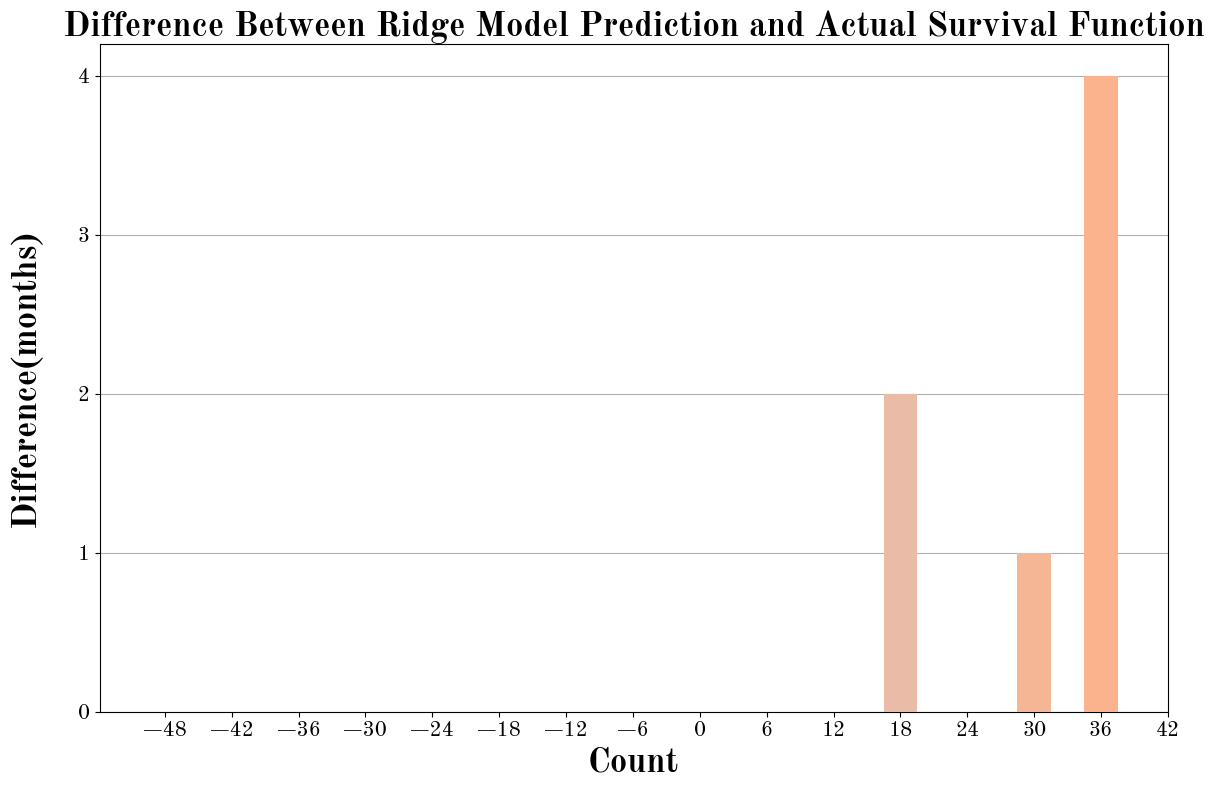

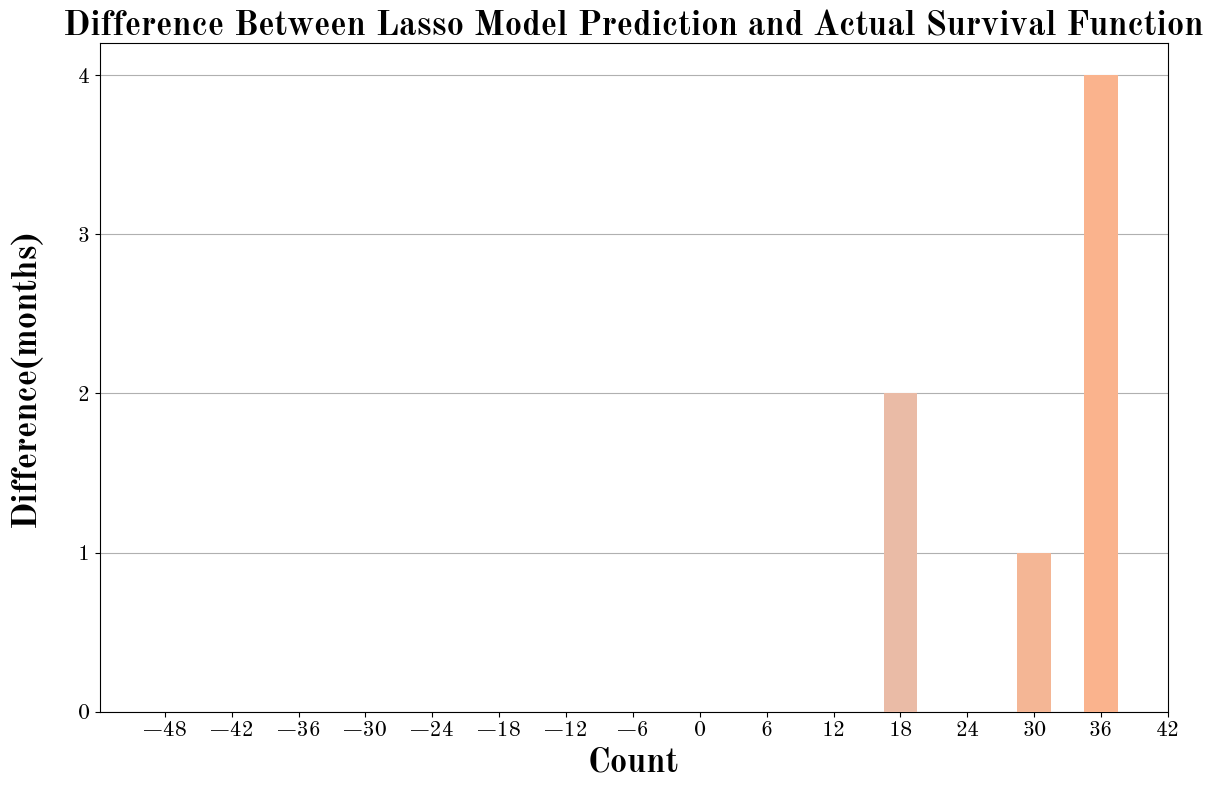

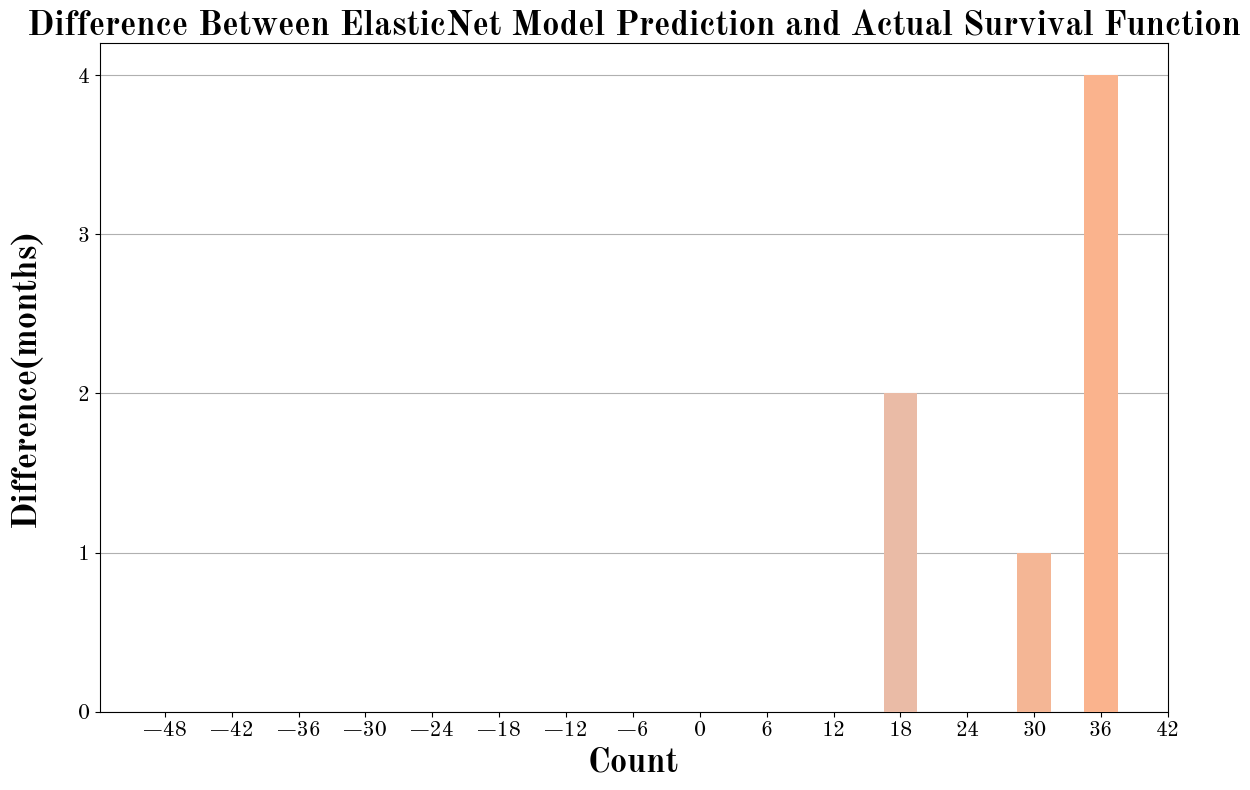

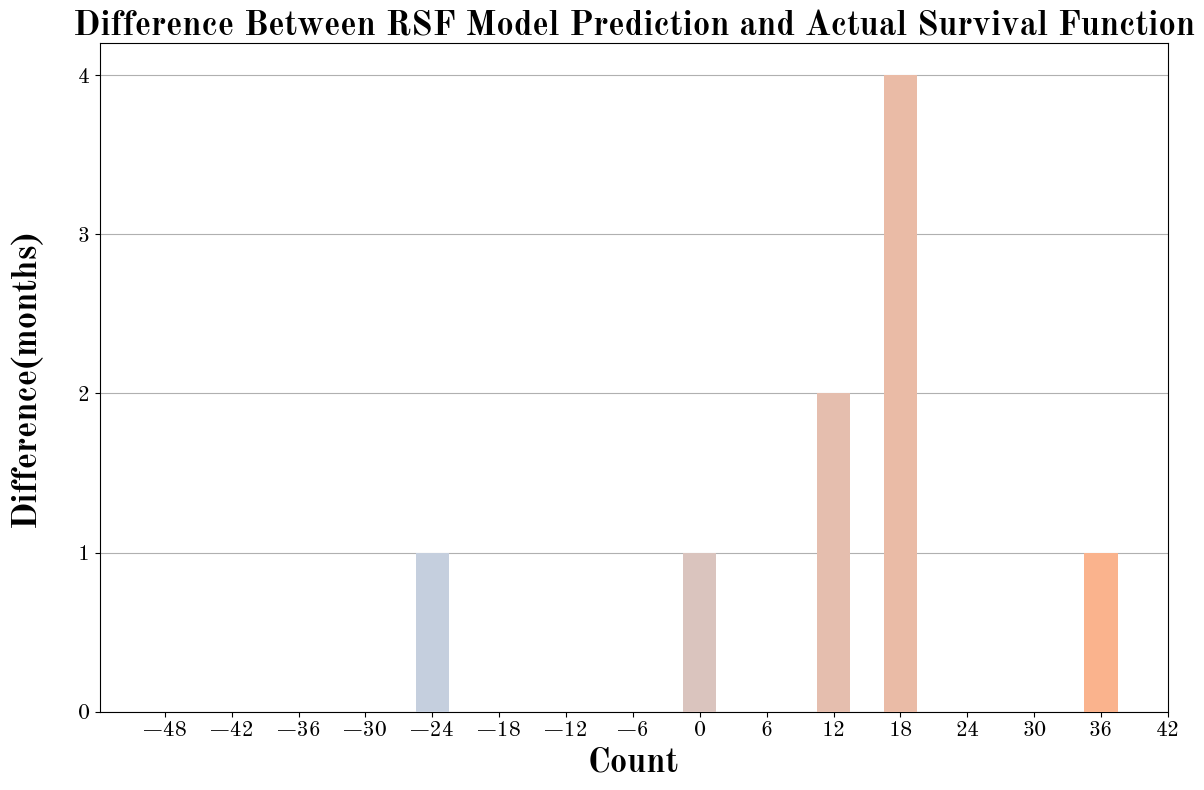

In [26]:
from sksurv.datasets import get_x_y
from sksurv.metrics import integrated_brier_score
from Utils.plot_functions import get_color_gradient

baseline_hazards = []
models_list = [cphs_ridge, cphs_lasso, cphs_elastic]

for models in models_list:
    baseline_hazards = [indv_model.baseline_hazard_ for indv_model in models]
    concatenated_baseline_hazards = pd.concat(baseline_hazards, axis=1)
    pooled_baseline_hazard = concatenated_baseline_hazards.mean(axis=1)
    baseline_hazards.append(pooled_baseline_hazard)
model = CoxPHSurvivalAnalysis(alpha=0.1)
x_train, y_train = get_x_y(dfs_train[0], attr_labels=["Event", "M"], pos_label=1)
model.fit(x_train, y_train)

cph_models_coef = [results, results_ridge, results_lasso, results_elastic]
labels = ['Cox PH', 'Ridge', 'Lasso', 'ElasticNet']
path = ['cox_ph', 'ridge', 'lasso', 'elastic']
ibs_list = []

df_test = dfs_test[0]
df_test = df_test[df_test['Event'] ==1]
x_test, y_test = get_x_y(df_test, attr_labels=["Event", "M"], pos_label=1)
for i, (params, baseline) in enumerate(zip(cph_models_coef, baseline_hazards)):
    model.coef_ = params['coef']
    model.baseline_hazard_ = baseline
    # prediction = model.predict(x_test)
    # print("##############")
    # print(prediction)
    # print(y_test)
    # print(1-(baseline.values*prediction))
    
    plot_bar_difference(model, dfs_test[0], labels[i], 'adni3/'+path[i])

plot_bar_difference(rsfs[0][0], dfs_test[0], 'RSF', 'adni3/rsf')